# CS-510 Final Project
## Next-day rain prediction in Australia

Import libraries:

In [1]:
# Data wrangling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Missing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# Algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Our own functions for this project
import utils as helper_functions

Set pandas and matplotlib configuration:

In [2]:
# Show up to 20 columns
pd.set_option('display.max_columns', 20)
# Set style to matplotlib
plt.style.use('default')
# Set font scale to seaborn and matplotlib
sns.set(font_scale=1)
plt.rcParams.update({'font.size': 20})

Import the dataset:

In [3]:
# Import data
data = pd.read_csv('data/weatherAUS.csv')
initial_length = len(data)

## 1. Dataset Description

Rain in Australia is a dataset available on Kaggle (https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) consisting of daily observations of weather data recorded in different locations over a 9-year period. There are 23 measurements and a target column that flags if it rained the following day. 

**The goal** is to train a model that can perform next-day rain prediction given today's measurements. 

| **Column Name** | **Definition** | **Units** |
| --------------- | -------------- | --------- |
| `Date` | Date of the observation | - |
| `Location` | Location of the weather station | - |
| `MinTemp` | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `MaxTemp` | Maximum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `Rainfall` | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimeter | Millimeters |
| `Evaporation` | "Class A" pan evaporation in the 24 hours to 9am | Millimeters |
| `Sunshine` | Bright sunshine in the 24 hours to midnight | Hours |
| `WindGustDir` | Direction of the strongest wind gust in the 24 hours to midnight | 16 compass points |
| `WindGustSpeed` | Speed of the strongest wind gust in the 24 hours to midnight | Kilometers per hour |
| `WindDir9am` | Direction of the wind at 9am | 16 compass points |
| `WindDir3pm` | Direction of the wind at 3pm | 16 compass points |
| `WindSpeed9am` | Speed of the wind at 9am | Kilometers per hour |
| `WindSpeed3pm` | Speed of the wind at 3pm | Kilometers per hour |
| `Humidity9am` | Relative humidity at 9am | Percent |
| `Humidity3pm` | Relative humidity at 3pm | Percent |
| `Pressure9am` | Atmospheric pressure reduced to mean sea level at 9am | Hectopascals |
| `Pressure3pm` | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascals |
| `Cloud9am` | Fraction of sky obscured by cloud at 9am | Eighths |
| `Cloud3pm` | Fraction of sky obscured by cloud at 3pm | Eighths |
| `Temp9am` | Temparature at 9am | Degrees Celsius |
| `Temp3pm` | Temparature at 3am | Degrees Celsius |
| `RainToday` | Did the current day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |
| `RainTomorrow` | Did the next day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |

## 2. Pre-processing

### 2.1 Missing Values

Around 60% of the observations have at least one feature value missing.

In [4]:
round(sum(data.isna().sum(axis=1) != 0)/initial_length, 3)

0.603

Drop `RISK_MM`. This feature was used to create the target class so including it would leak useful information to the model.

In [5]:
data.drop(columns=['RISK_MM'], inplace=True)

When wind speed is 0 the direction is 'None', so we add a new category to replace the NAs.

In [6]:
data.loc[data['WindSpeed3pm'] == 0, 'WindDir3pm'] = 'None'
data.loc[data['WindSpeed9am'] == 0, 'WindDir9am'] = 'None'

Drop the rest of missing values in wind-related features at specific times of the day.

In [7]:
data.dropna(subset=['WindDir3pm', 'WindDir9am', 'WindSpeed3pm', 'WindSpeed9am'], how='any', inplace=True)

Whenever `WindGustSpeed` takes a `NaN` value, `WindGustDir` also does. Replace `NaN` values in `WindGustSpeed` with 0 and, as we did for `WindDir9am/3pm`, set `WindGustDir` to 'None' accordingly.

In [8]:
print(data[data['WindGustSpeed'].isna()][['WindGustDir', 'WindGustSpeed']].isna().sum())

data.loc[:,'WindGustSpeed'].fillna(value=0, inplace=True)
data.loc[data['WindGustSpeed'] == 0, 'WindGustDir'] = 'None'

WindGustDir      6718
WindGustSpeed    6718
dtype: int64


Let's look at the % of missing values by column. There are 4 variables that are especially problematic with ~40% of missing values: `Evaporation`, `Sunshine`, `Cloud9am` and `Cloud3pm`.

In [9]:
print(100 * data.isnull().sum() / len(data))

Date              0.000000
Location          0.000000
MinTemp           0.183406
MaxTemp           0.112201
Rainfall          0.795477
Evaporation      42.191950
Sunshine         46.869875
WindGustDir       0.009350
WindGustSpeed     0.000000
WindDir9am        0.000000
WindDir3pm        0.000000
WindSpeed9am      0.000000
WindSpeed3pm      0.000000
Humidity9am       0.854455
Humidity3pm       1.215513
Pressure9am       8.730113
Pressure3pm       8.684082
Cloud9am         37.573722
Cloud3pm         39.056072
Temp9am           0.271872
Temp3pm           0.609914
RainToday         0.795477
RainTomorrow      0.000000
dtype: float64


We also noticed that some locations have been consistently failing to report measurements of `Evaporation`, `Sunshine`, `Cloud9am` and `Cloud3pm`. The chart below illustrates this issue (i.e. the percentage of NaN values is 100%).

In [10]:
def custom_stacked_bar(series):
    """
    Helper function to create a stacked bar of %.
    :param series: A pandas Series.
    :return: A pandas Series with the appropriate data transformations.
    """
    return series.sum()/(series.count() * 4) * 100

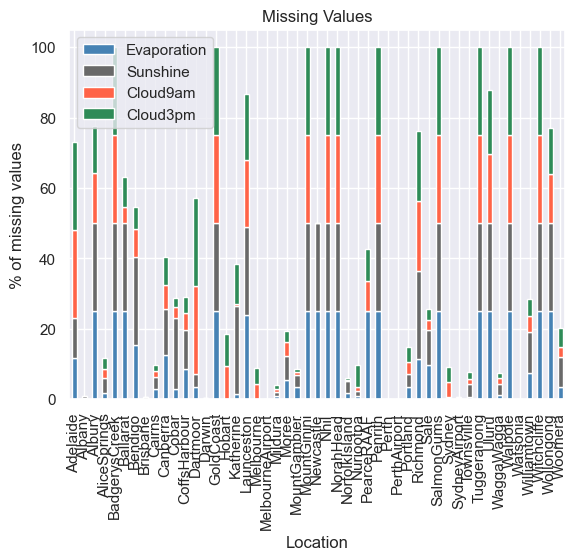

In [11]:
location_analysis = data.isna().groupby(data['Location'])[['Evaporation',
                                                           'Sunshine',
                                                           'Cloud9am',
                                                           'Cloud3pm']].apply(custom_stacked_bar)
location_analysis.plot(kind='bar', stacked=True, color=['steelblue', 'dimgray', 'tomato', 'seagreen'])
plt.ylabel('% of missing values')
plt.title('Missing Values')
plt.show();

In the light of the results and considering that these features' missing values are responsible for ~40% of incomplete observations, we think it's better to drop the features instead of inputing the values, as the imputation could potentially add noise to the dataset given that only 60% of true observations would be available. 

In [12]:
data.drop(columns=['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], inplace=True)

At this stage, all the features have approximately less than 1% of missing values except for `Pressure9am` and `Pressure3pm`. These are populated with ~8% of missing values and it seems worth it to impute the values instead of dropping nearly one tenth of the dataset. 

For this, we will start by dropping rows with `NaNs` due to other columns' missing records, but not `Pressure9am`, `Pressure3pm` (that's only 1%).

In [13]:
data.dropna(subset=data.columns.difference(['Pressure9am', 'Pressure3pm']), how='any', inplace=True)

Next, we will will impute the missing values in `Pressure9am` and `Pressure3pm` using scikit-learn's `IterativeImputer` using only numerical features. This will create multiple models to predict the values in `Pressure9am` and `Pressure3pm` based on observed, non-missing data.

In [14]:
imp_data = data._get_numeric_data()

imp = IterativeImputer(random_state=0, max_iter=50)
imp.fit(imp_data)
imp_results = imp.transform(imp_data)

Select data imputed and add it to the main dataframe:

In [15]:
index_a = imp_data.columns.get_loc('Pressure9am')
index_b = imp_data.columns.get_loc('Pressure3pm')

data['Pressure9am'] = imp_results[:, index_a]
data['Pressure3pm'] = imp_results[:, index_b]

Furthermore, although it doesn't present missing values, `Location` can be also drop it as we won't use it for the analysis. 

In [16]:
data.drop(columns=['Location'], inplace=True)

Finally, let's compute % of observations lost due to handling missing data with respect to the original length of the dataset.

In [17]:
print('% of instances lost', (1 - len(data)/initial_length) * 100)

% of instances lost 4.638765621373764


**We've only lost 4.63% of instances** after carefully dealing with missing values and rightly dropped 4 features. If we would have applied the `dropna()` method at the very beggining, **60% of instances would have been completely lost.**

In [18]:
if data.isna().values.any() == False:
    print('No missing values found')

No missing values found


Make a clean copy of the dataset.

In [19]:
clean_data = data.reset_index(drop=True).copy()

### 2.2 Data Distribution

We can start the exploratory analysis by looking at the distribution of the variables with respect to the class label (see `utils.py` to check the code that generated this chart). 

Most features are **normally distributed** except for `Rainfall`, which shows a long right tail with outliers. **Humidity indicators** are pontentially **helpful** at predicting next-day rain.

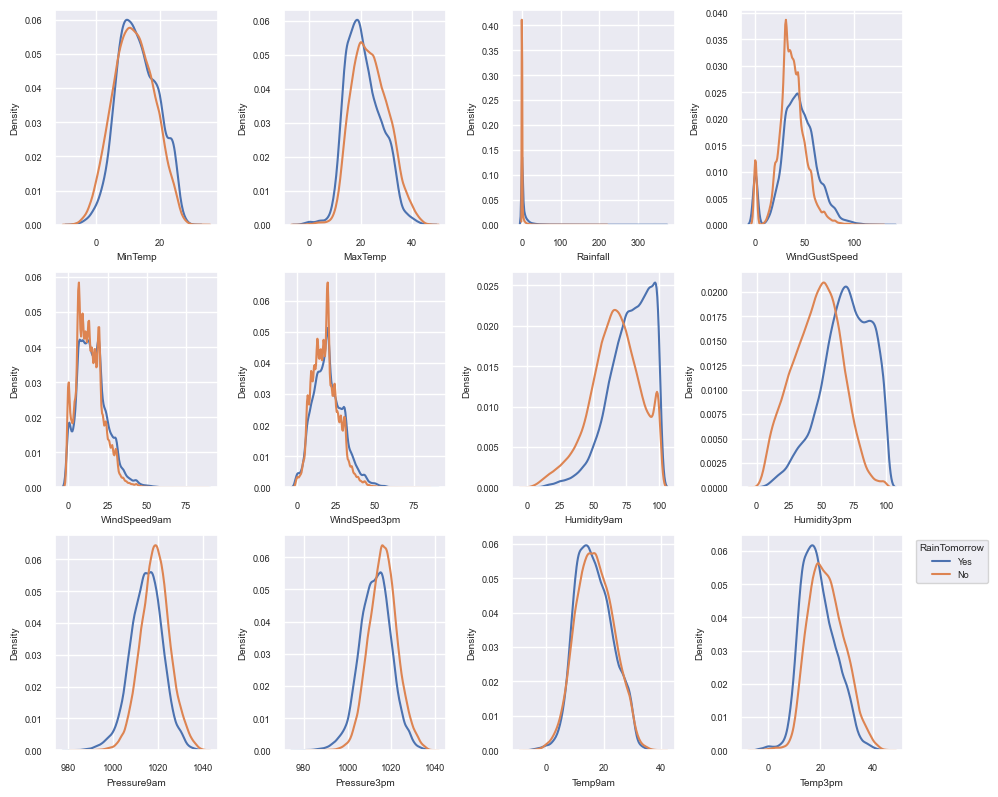

In [20]:
helper_functions.classification_density(data=clean_data, rows_subplot=3, columns_subplot=4, 
                                        class_label='RainTomorrow', text_size=0.6, size=(10, 8))

### 2.3 Outlier Detection

Let's start this section by plotting a boxplot of each feature split by class (see `utils.py` in this directory for more info about how this chart was generated). As seen before, all the features are **similary distributed** regardless of when it rained, however, one can notice that the day before it rained showed higher humidity at 9am and 3pm, and lower atmospheric pressure at 9am and 3pm.

Nevertheless, there are still a **large number of outliers** that fall out of the whiskers.

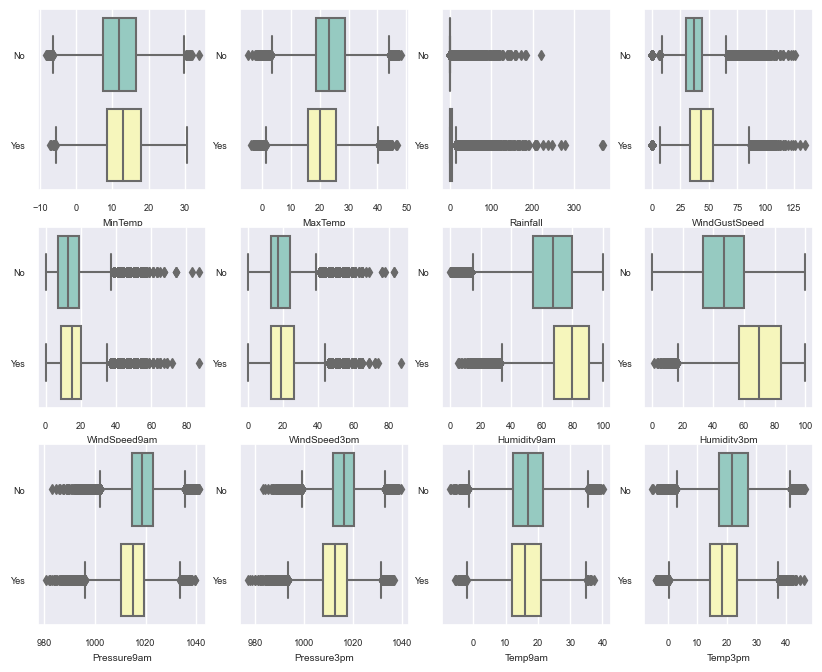

In [21]:
helper_functions.classification_boxplot(data=clean_data, rows_subplot=3, columns_subplot=4,
                                        class_label='RainTomorrow', text_size=0.6, size=(10, 8))

We are going to deal with the outliers by replacing the values that fall out the range of the lower and upper whiskers with the median value of the feature. These thresholds for identifying outliers are calculated as $M + / − 1.5 * IQR$, where $M$ is the median of the distribution and $IQR$ is the Interquartile range.

Please, go to `utils.py` to look at the code of the function that applied this transformation. 

In [22]:
boundaries = helper_functions.iqr_outlier_detection(data=clean_data, iqr_k=1.5, impute=True)

In [23]:
print(boundaries)

               lower_whisker  upper_whisker
MinTemp            -1.800000      25.800000
MaxTemp             7.250000      38.150000
Rainfall           -0.900000       0.900000
WindGustSpeed      13.000000      61.000000
WindSpeed9am       -5.000000      31.000000
WindSpeed3pm        2.500000      35.500000
Humidity9am        31.000000     109.000000
Humidity3pm         7.000000      97.000000
Pressure9am      1004.650000    1031.350000
Pressure3pm      1002.093544    1029.093544
Temp9am             2.750000      30.650000
Temp3pm             6.250000      35.950000


### 2.4 Categorical Features

Firstly, the exact date gives us a level of detail that we probably won't need. Instead, it would be useful to extract the month from it. 

In [24]:
clean_data['Date'] = pd.DatetimeIndex(clean_data['Date']).month
clean_data = clean_data.rename(columns={'Date': 'Month'})

Secondly, the feature `RainToday` and target class `RainTomorrow` will be converted to binary: 'yes' 1 and 'no' 0.

In [25]:
clean_data['RainTomorrow'] = clean_data['RainTomorrow'].map({'Yes': 1, 'No': 0})
clean_data['RainToday'] = clean_data['RainToday'].map({'Yes': 1, 'No': 0})

For the rest of categorical variables (`WindGustDir`, `WindDir9am`, `WindDir3pm`) we will user ordinal encoding, and each category will be represented as an integer. 

In [26]:
encoded_data = helper_functions.encode_categorical_features(clean_data, method='ordinal')

### 2.5 Feature Selection

There is a moderate to high correlation between features that measure the same weather observation at different times of the day, e.g. `Pressure9am` and `Pressure3pm` or `WindSpeed9am` and `WindSpeed3pm`. Also, the temperature features `MaxTemp` and `MinTemp` are moderately correlated with `Temp9am` and `Temp3pm`.

Moreover, humidity (`Humidity9am` and `Humidity3pm`) and preassure (`Pressure9am` and `Pressure3pm`) seem to be negatively associated with temperature (`Temp9am` and `Temp3pm`), so that the higher these two are, the lower the temperature in the area. 

The target class `RainTomorrow` seems to be moderately associated with `RainToday` and both humidity features `Humidity9am` and `Humidity3pm`, so we expect that these three will be useful for next-day rain prediction in Australia.

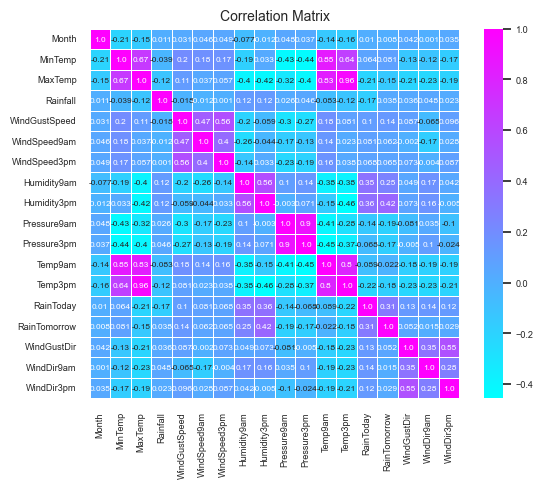

In [27]:
cor = np.corrcoef(encoded_data, rowvar=0)

sns.heatmap(np.round(cor,3), linewidth=0.5, 
            annot=True, cmap='cool', fmt='.2', 
            square=True, annot_kws={"size": 6},
            xticklabels=encoded_data.columns,
            yticklabels=encoded_data.columns)
plt.title('Correlation Matrix', size=10)
plt.show();

Another way to select features would be to check their predictive power. For this purpose, fitting a Random Forest to the data would help us extract the individual importance scores in the model. Before we do this, let's first normalize the values in each column and split the data into training and testing: (see `utils.py` to learn more about this transformation and the feature importance extractor).

In [28]:
X_train, X_test, y_train, y_test = helper_functions.split_and_scale_data(encoded_data, method='minmax',
                                                                         testsize=0.20, taget_class='RainTomorrow')

In [29]:
features, importance = helper_functions.feature_importance(X_train, y_train)

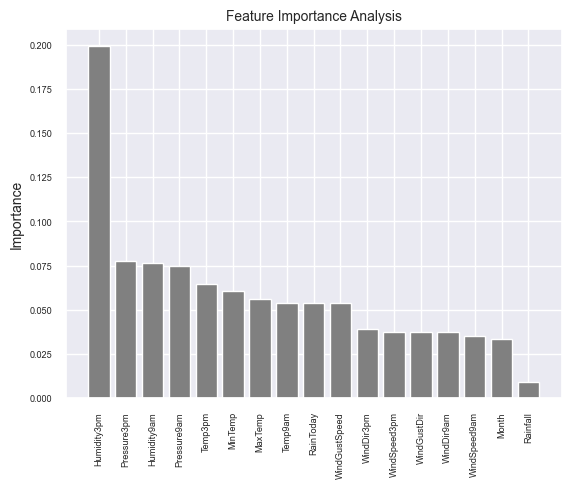

In [30]:
plt.bar(features, importance, width=0.8, color='gray')
plt.xticks(range(len(features)), features, rotation=90)
plt.ylabel('Importance', size=10)
plt.title('Feature Importance Analysis', size=10)
plt.show();

Based on the results above, `Humidity3pm` is the most important feature in the dataset. `Rainfall`, however, doesn't contribute much to the prediction of rain in Australia. 

Lastly, we can also run a simulation to see the impact of training a model with multiple number of variables. It will train as many models as features in the dataset and iteratively drop the features with the least importance or predictive power (see `utils.py` for the code that runs this simulation).

In [31]:
acc, f1, recall, precision, n_features, features = helper_functions.tree_based_feature_analysis(X_train,
                                                                                                X_test,
                                                                                                y_train,
                                                                                                y_test)

100%|███████████████████████████████████████████| 17/17 [05:36<00:00, 19.81s/it]


Plot the results obtained:

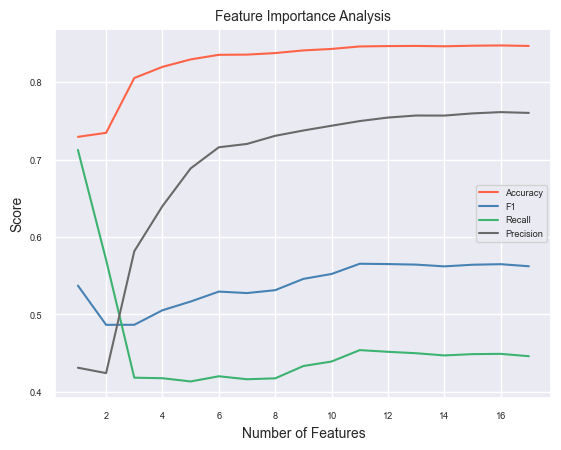

In [32]:
plt.plot(n_features, acc, label='Accuracy', color='tomato')
plt.plot(n_features, f1, label='F1', color='steelblue')
plt.plot(n_features, recall, label='Recall', color='mediumseagreen')
plt.plot(n_features, precision, label='Precision', color='dimgray')
plt.title('Feature Importance Analysis', size=10)
plt.xlabel('Number of Features', size=10)
plt.ylabel('Score', size=10)
plt.legend()
plt.show();

The model's performance deteriorates when the 7th feature is dropped (`RainToday`), which means that features `Rainfall`, `Month`, `WindSpeed9am`, `WindGustDir`, `WindSpeed3pm`, `WindDir9am` and are not particulary helpful for this problem and we will not use them for training the model.

In [33]:
set(features[0]) - set(features[6])

{'Month',
 'Rainfall',
 'WindDir9am',
 'WindGustDir',
 'WindSpeed3pm',
 'WindSpeed9am'}

Drop the features from the training and test sets.

In [34]:
drop_columns = ['Rainfall', 'Month', 'WindSpeed9am', 
                'WindGustDir', 'WindSpeed3pm', 'WindDir9am']

X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

## 3. Model Building

### 3.1 Classification Algorithms

The training set consists of 108,477 observations and 10 features. In order to deal with the imbalanced nature of the data we will use random undersampling and regularization. 

In [35]:
X_train.shape

(108477, 11)

In order to make an informed decision about which algorithm
could better solve this problem, let's train a selection of five
machine learning models and analyze multiple performance
metrics on a test dataset

In [36]:
models = []
models.append(('DT', DecisionTreeClassifier)) 
models.append(('LSVC', LinearSVC))
models.append(('RF', RandomForestClassifier))
models.append(('LR', LogisticRegression))
models.append(('SGD', SGDClassifier))

**Method A: Regularization**

In [37]:
summary_df_cs = helper_functions.stratified_cv(
    X=X_train, y=y_train, models=models, k=10, method='regularization', weight0=0.2, weight1=0.8)

100%|█████████████████████████████████████████████| 5/5 [01:11<00:00, 14.34s/it]


In [38]:
summary_df_cs

,algorithm_name,accuracy,f1,precision,recall,method,folds,weight0,weight1
0,DT,0.780571,0.496692,0.502270,0.491300,regularization,10,0.2,0.8
1,LSVC,0.740516,0.566541,0.448326,0.769473,regularization,10,0.2,0.8
2,RF,0.845497,0.560158,0.751545,0.446625,regularization,10,0.2,0.8
3,LR,0.738774,0.565468,0.446377,0.771272,regularization,10,0.2,0.8
4,SGD,0.751182,0.570784,0.462401,0.749728,regularization,10,0.2,0.8


**Method B: Undersampling**

In [39]:
summary_df_under = helper_functions.stratified_cv(
    X=X_train, y=y_train, models=models, k=10, method='sampling', apply=RandomUnderSampler)

100%|█████████████████████████████████████████████| 5/5 [00:37<00:00,  7.43s/it]


In [40]:
summary_df_under

,algorithm_name,accuracy,f1,precision,recall,method,folds,apply
0,DT,0.699079,0.506077,0.396465,0.699491,sampling,10,RandomUnderSampler
1,LSVC,0.756815,0.574633,0.467582,0.745337,sampling,10,RandomUnderSampler
2,RF,0.784931,0.611594,0.508052,0.768260,sampling,10,RandomUnderSampler
3,LR,0.755782,0.574199,0.466287,0.747177,sampling,10,RandomUnderSampler
4,SGD,0.771933,0.579515,0.489735,0.712584,sampling,10,RandomUnderSampler


Given that most observations belong to the majority class (not rain), the level of accuracy is not a good indicator of performance. Instead, F-1 score is calculated as the **harmonic mean of precision and recall**, and quantifies the correctness and confidence of a model's predictions. 

In this respect, **random forest and undersampling** resulted in the best strategy to tackle this problem. It is also important to note that undersampling was overall a better solution to deal with the class-imbalanced nature of the data than regularization. 

### 3.2 Training and Evaluation

For the final step of the model building phase, we are going to perform
**hyper-parameter tuning** on the random forest model by training
and testing 32 different configurations of the algorithm using
undersampling. The best resulting model will be selected based
on the **F-1 score** obtained from **cross validating** the performance on 5 folds of the data.

Create an instance of the model:

In [41]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

Define the hyper-parameters to test:

In [42]:
n_estimators = [500, 1000]
max_depth = [30, 50]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]
bootstrap = [True, False]

Create a dictionary of the hyper-parameters:

In [43]:
param_grid_rf = [{
 'model__n_estimators': n_estimators,
 'model__max_depth' : max_depth,
 'model__min_samples_split': min_samples_split,
 'model__min_samples_leaf': min_samples_leaf,
 'model__bootstrap': bootstrap
}]

Perform hyper-parameter tuning using undersampling (see `utils.py` to learn more about how this function works):

In [44]:
best_rf = helper_functions.hyperparameter_tuning(
    X=X_train, y=y_train, model=rf, hyperpar_grid=param_grid_rf,
    sampling_method=RandomUnderSampler, folds=5, optimize='f1', refit_model=True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Parameters: {'model__bootstrap': True, 'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500} CV Score: 0.6155761508547326


We can now predict on the test set and create a classification report to evaluate the model's performance.

In [45]:
results = best_rf.predict(X_test)
print(classification_report(y_pred=results, y_true=y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9267    0.7877    0.8516     21143
           1     0.5094    0.7797    0.6162      5977

    accuracy                         0.7860     27120
   macro avg     0.7181    0.7837    0.7339     27120
weighted avg     0.8347    0.7860    0.7997     27120



Finally, let's plot the ROC curve of the model and compute the area under the curve.

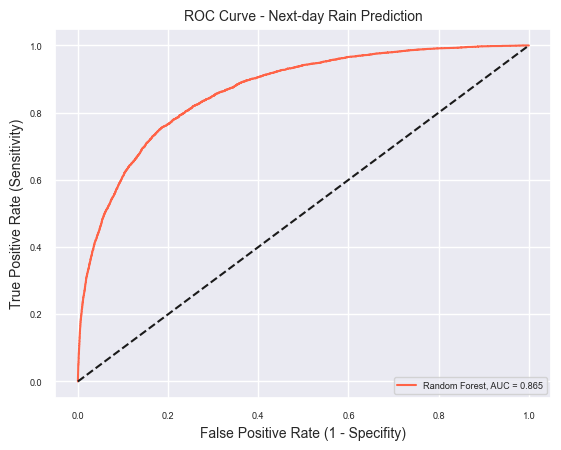

[CV 1/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.607 total time= 1.6min
[CV 2/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.618 total time= 1.5min
[CV 3/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=1000;, score=0.612 total time= 1.3min
[CV 3/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=1000;, score=0.612 total time= 1.3min
[CV 3/5] END model__bootstrap=True, model__max_depth=50, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.613 total time= 1.6min
[CV 4/5] END model__bootstrap=True, model__max_depth=50, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=

[CV 2/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.623 total time=  46.1s
[CV 1/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.608 total time=  45.5s
[CV 4/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.616 total time=  44.1s
[CV 5/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.618 total time= 1.5min
[CV 3/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=500;, score=0.612 total time=  39.1s
[CV 1/5] END model__bootstrap=True, model__max_depth=50, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.606

[CV 5/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.619 total time=  45.6s
[CV 4/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.617 total time= 1.6min
[CV 3/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=500;, score=0.612 total time=  40.8s
[CV 1/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=1000;, score=0.605 total time= 1.3min
[CV 1/5] END model__bootstrap=True, model__max_depth=30, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=1000;, score=0.605 total time= 1.3min
[CV 5/5] END model__bootstrap=True, model__max_depth=50, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.61

In [46]:
pred = best_rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
roc_auc = roc_auc_score(y_test, pred[:, 1])

plt.plot(fpr, tpr, label='{}, AUC = {}'.format('Random Forest', round(roc_auc, 3)), color='tomato')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (1 - Specifity)', size=10)
plt.ylabel('True Positive Rate (Sensitivity)', size=10)
plt.title('ROC Curve - Next-day Rain Prediction', size=10)
plt.legend(loc="lower right")
plt.show();

## 4. Discussion

### 4.1 Conclusions

- Next-day prediction in Australia is an imbalaced data problem and techniques such as regularization or undersampling are necessary.
- There are very few weather measurements that help predict rain in a linear way, therefore, there must be non-linear relationships in the data with the target class.
- Dealing with missing values and detecting outliers seems to be a very important step of the process. 
- Using a random forest and undersampling has resulted in the best strategy to tackle this problem. 
- While the final model was able to predict 78% of rain observations correctly, it has a relatively low precision of 51%.

### 4.2 Future Work

- In this work we have implemented regularization and undersampling in isolation, however, both techniques could be applied together to better handle the class-imbalanced problem.
- Given that this dataset contains close to 150K observations, it seems to be sufficiently large to train advanced deep learning models like neural networks on it. These kind of models have proven to be very successful when large amounts of data are available and could possibly outperform our results.
- Our approach to solving this problem ignored the location where the rain was predicted in, however, Australia is vast continent and regions are marked by very different temperatures and levels of precipitation depending on their longitude and latitude. Taking geographical features into consideration could potentially improve the models' ability to predict rain.